# Business Understanding

Tujuan: Mengetahui sentimen pengguna terhadap aplikasi DANA berdasarkan ulasan yang tersedia di Google Play Store. Dengan menganalisis sentimen, pihak pengembang dapat mengambil keputusan untuk memperbaiki aplikasi atau meningkatkan kualitas layanan berdasarkan sentimen pengguna.

Kebutuhan Bisnis: Meningkatkan kepuasan pengguna dengan memahami keluhan atau apresiasi melalui ulasan. Mengetahui pola umum sentimen untuk menilai performa aplikasi.



# Data Understanding

In [ ]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

data = pd.read_csv('labelled_10kdana_reviews.csv')
print(data.info())
missing_values = data.isnull().sum()
print("Jumlah nilai kosong di setiap kolom:")
print(missing_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user             10000 non-null  object 
 1   rating           10000 non-null  int64  
 2   review           10000 non-null  object 
 3   date             10000 non-null  object 
 4   sentiment        10000 non-null  object 
 5   sentiment score  10000 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 468.9+ KB
None
Jumlah nilai kosong di setiap kolom:
user               0
rating             0
review             0
date               0
sentiment          0
sentiment score    0
dtype: int64


In [ ]:
print(data.head())

                     user  rating  \
0                    Gina       5   
1  Juliansyah nur firdaus       2   
2    Zauma Ma'ruf Hidayat       1   
3           Rizky Ramdani       2   
4               Love Bird       2   

                                              review                 date  \
0                                            menarik  2024-09-23 15:32:00   
1                           banyak potongan sekarang  2024-09-23 15:30:51   
2  dana sekarang agak bermasalah saya transfer sa...  2024-09-23 15:30:43   
3         Dana cicil saya belum aktif mohon di bantu  2024-09-23 15:30:00   
4                         Mau tarik qris di persulit  2024-09-23 15:28:41   

  sentiment  sentiment score  
0  positive         0.998741  
1  negative         0.956343  
2  negative         0.993481  
3   neutral         0.998889  
4   neutral         0.589940  


In [ ]:
# Menghitung distribusi label sentimen
print(data['sentiment'].value_counts())

sentiment
positive    5478
negative    3880
neutral      642
Name: count, dtype: int64


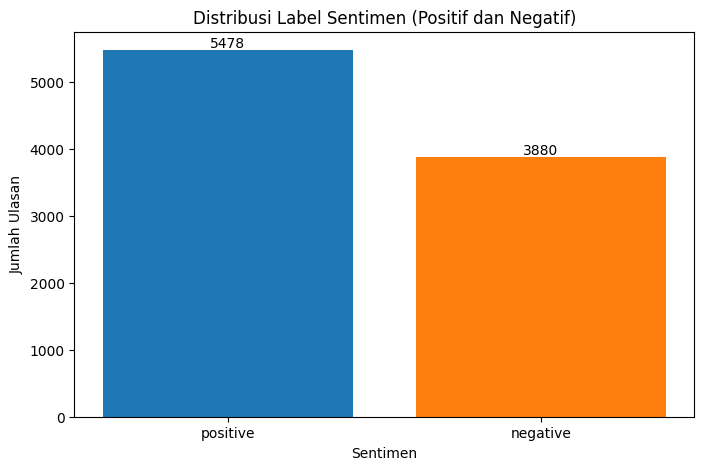

In [ ]:
# Filter hanya untuk sentimen positif dan negatif
sentiment_counts = data[data['sentiment'].isin(['positive', 'negative'])]['sentiment'].value_counts()

# Membuat grafik batang
plt.figure(figsize=(8, 5))
bars = plt.bar(sentiment_counts.index, sentiment_counts.values, color=['tab:blue', 'tab:orange'])

# Menambahkan label jumlah di atas setiap batang
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.title('Distribusi Label Sentimen (Positif dan Negatif)')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Ulasan')
plt.show()


# Data Preparation

In [ ]:
import re
import string

# Konversi teks menjadi huruf kecil (lowercase)
def lower_text(review_text):
    return review_text.lower()

data['clean_review'] = data['review'].apply(lambda x: lower_text(str(x)))

# Menghapus hyperlink dari teks
def remove_hyperlinks(review_text):
    hyperlink_pattern = r'http[s]?://\S+|www\.\S+'
    return re.sub(hyperlink_pattern, '', review_text)

data['clean_review'] = data['clean_review'].apply(remove_hyperlinks)

# Menghapus emoji dari teks menggunakan regex dan nilai unicode dari emoji
def remove_emoji(review_text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # Transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # Flags
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', review_text)

data['clean_review'] = data['clean_review'].apply(remove_emoji)

# Menghapus hashtag dari teks
def remove_hashtag(review_text):
    hashtag_pattern = r'#\w+'
    return re.sub(hashtag_pattern, '', review_text)

data['clean_review'] = data['clean_review'].apply(remove_hashtag)

# Menghapus angka dari teks
def remove_number(review_text):
    number_pattern = r'\d+'
    return re.sub(number_pattern, '', review_text)

data['clean_review'] = data['clean_review'].apply(remove_number)

# Menghapus tanda baca (punctuation) dari teks
def remove_punctuation(review_text):
    return review_text.translate(str.maketrans('', '', string.punctuation))

data['clean_review'] = data['clean_review'].apply(remove_punctuation)

# Menghapus superscript dalam teks yang biasa digunakan untuk mengulang kata
def remove_superscript(review_text):
    superscript_pattern = re.compile(r"[\u2070-\u209F]")
    return superscript_pattern.sub(r'', review_text)

data['clean_review'] = data['clean_review'].apply(remove_superscript)

# Fungsi untuk membatasi pengulangan huruf menjadi satu karakter
def word_repetition_single(review_text):
    return re.sub(r'(.)\1+', r'\1', review_text)

data['clean_review'] = data['clean_review'].apply(word_repetition_single)

# Menghapus spasi berlebih dalam teks
def remove_extra_whitespaces(review_text):
    return re.sub(r'\s+', ' ', review_text).strip()

data['clean_review'] = data['clean_review'].apply(remove_extra_whitespaces)

In [ ]:
print(data[['review', 'clean_review']].head())

                                              review  \
0                                            menarik   
1                           banyak potongan sekarang   
2  dana sekarang agak bermasalah saya transfer sa...   
3         Dana cicil saya belum aktif mohon di bantu   
4                         Mau tarik qris di persulit   

                                        clean_review  
0                                            menarik  
1                           banyak potongan sekarang  
2  dana sekarang agak bermasalah saya transfer sa...  
3         dana cicil saya belum aktif mohon di bantu  
4                         mau tarik qris di persulit  


In [ ]:
pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.8 MB/s eta 0:00:00


In [ ]:
!gdown --id 1cXaOtuw6xqWL6KDjZqvkzGYsiyyr0X1y

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1cXaOtuw6xqWL6KDjZqvkzGYsiyyr0X1y
To: /content/slang.txt
100% 32.8k/32.8k [00:00<00:00, 94.1MB/s]


In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

nltk.download('punkt_tab')
nltk.download('stopwords')

# Load stopwords Bahasa Indonesia
stop_words = set(stopwords.words('indonesian'))

# Fungsi untuk membaca kamus slang dari file dan mengubahnya menjadi dictionary
def load_slang_dict(slang_file_path):
    slang_dict = {}
    with open(slang_file_path, 'r', encoding='utf-8') as file:
        for line in file:
            slang, formal = line.strip().split(':')
            slang_dict[slang] = formal
    return slang_dict

slang_file_path = 'slang.txt'

# Membaca kamus slang
slang_dict = load_slang_dict(slang_file_path)

# Fungsi untuk mengganti kata-kata slang dalam teks menjadi kata baku berdasarkan kamus slang
def normalize_slang(text, slang_dict):
    words = text.split()
    normalized_text = ' '.join([slang_dict[word] if word in slang_dict else word for word in words])
    return normalized_text

# Normalisasi slang pada teks ulasan sebelum proses tokenisasi
data['clean_review'] = data['clean_review'].apply(lambda x: normalize_slang(x, slang_dict))

# Tokenisasi - Memecah teks menjadi kata-kata (token)
def tokenize_text(review_text):
    return word_tokenize(review_text)

data['clean_review_tokenized'] = data['clean_review'].apply(tokenize_text)

# Menghapus Stopwords - Menghapus kata yang tidak penting
def remove_stopwords(text_tokens):
    return [word for word in text_tokens if word not in stop_words]

data['clean_review_tokenized'] = data['clean_review_tokenized'].apply(remove_stopwords)

# Stemming - Mengubah kata ke bentuk dasar menggunakan Sastrawi
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming_text(text_tokens):
    return [stemmer.stem(word) for word in text_tokens]

data['clean_review_stemmed'] = data['clean_review_tokenized'].apply(stemming_text)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import gensim
from google.colab import drive

# Mount Google Drive untuk mengakses model FastText pre-trained
drive.mount('/content/drive')

# Path ke model FastText pre-trained
model_path = '/content/drive/MyDrive/cc.id.300.bin'

# Memuat model FastText
print("Memuat model FastText...")
fasttext_model = gensim.models.fasttext.load_facebook_vectors(model_path)

# Fungsi untuk mengonversi label sentimen menjadi numerik (1 untuk positif, -1 untuk negatif)
def convert_sentiment_label(sentiment):
    sentiment = sentiment.lower().strip()
    if sentiment == "positive":
        return 1
    elif sentiment == "negative":
        return -1
    else:
        return None

# Terapkan konversi pada kolom 'sentimen'
data['polarity'] = data['sentiment'].apply(convert_sentiment_label)

# Hapus baris dengan label None (yang bukan positif atau negatif)
data_filtered = data.dropna(subset=['polarity'])

# Memastikan elemen dalam kolom 'clean_review_stemmed' adalah string
data_filtered['clean_review_stemmed'] = data_filtered['clean_review_stemmed'].apply(
    lambda x: ' '.join(x) if isinstance(x, list) else x
)

# Tampilkan jumlah dari setiap label sentimen
print("\nDistribusi label setelah filter:")
print(data_filtered['polarity'].value_counts())

# Memisahkan fitur (X) dan label (y)
X = data_filtered['clean_review_stemmed']
y = data_filtered['polarity']

# Membagi dataset menjadi data latih dan uji (stratifikasi untuk mempertahankan distribusi label)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Fungsi untuk membuat rata-rata vektor dari embedding FastText
def get_sentence_embedding(sentence, model):
    words = sentence.split()
    word_vectors = [model[word] for word in words if word in model]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)  # Mengambil rata-rata vektor
    else:
        return np.zeros(model.vector_size)  # Jika kata tidak ditemukan, kembalikan vektor nol

# Konversi teks menjadi embedding FastText
print("Membuat embedding untuk data latih dan uji...")
X_train_embedding = np.array([get_sentence_embedding(sentence, fasttext_model) for sentence in X_train])
X_test_embedding = np.array([get_sentence_embedding(sentence, fasttext_model) for sentence in X_test])

# Output shape dari embedding FastText
print(f"Shape X_train_embedding: {X_train_embedding.shape}")
print(f"Shape X_test_embedding: {X_test_embedding.shape}")

Mounted at /content/drive
Memuat model FastText...

Distribusi label setelah filter:
polarity
 1.0    5478
-1.0    3880
Name: count, dtype: int64
Membuat embedding untuk data latih dan uji...
Shape X_train_embedding: (7486, 300)
Shape X_test_embedding: (1872, 300)


<ipython-input-10-88f1765702b0>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['clean_review_stemmed'] = data_filtered['clean_review_stemmed'].apply(


# Modelling

## Kernel Linear

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Definisikan parameter grid untuk kernel linear
param_grid_linear = {
    'C': [0.1, 1, 10, 100]  # Nilai regularisasi C
}

# Inisialisasi model SVM dengan kernel linear
svm_linear = SVC(kernel='linear')

# Inisialisasi GridSearchCV dengan 5-fold cross-validation
grid_search_linear = GridSearchCV(
    estimator=svm_linear,
    param_grid=param_grid_linear,
    scoring='accuracy',
    cv=5,
    return_train_score=True  # Tambahkan untuk mendapatkan skor training juga
)

# Latih model menggunakan GridSearchCV dengan input embedding
print("Optimasi model SVM kernel Linear menggunakan GridSearchCV...")
grid_search_linear.fit(X_train_embedding, y_train)

# Tampilkan parameter terbaik dan skor terbaik saat pelatihan
print("Best Parameters (Linear Kernel):", grid_search_linear.best_params_)
print("Best Mean Test Score (Linear Kernel):", grid_search_linear.best_score_)

# Tampilkan akurasi untuk setiap nilai C yang dicoba, dan simpan hasilnya dalam results_linear
results_linear = pd.DataFrame(grid_search_linear.cv_results_)
results_linear = results_linear[['param_C', 'mean_test_score', 'std_test_score']]

# Lakukan prediksi pada data uji untuk setiap model hasil GridSearchCV dan hitung akurasi uji
test_accuracies = []
for params in grid_search_linear.cv_results_['params']:
    svm_model = SVC(kernel='linear', C=params['C'])
    svm_model.fit(X_train_embedding, y_train)
    y_pred = svm_model.predict(X_test_embedding)
    test_accuracy = accuracy_score(y_test, y_pred)
    test_accuracies.append(test_accuracy)

# Tambahkan akurasi uji ke DataFrame hasil
results_linear['test_accuracy'] = test_accuracies

print("\nPerbandingan akurasi pada setiap nilai C (Mean Test Score dan Test Accuracy):")
print(results_linear)

# Ambil model terbaik dan lakukan prediksi pada data uji
best_svm_linear = grid_search_linear.best_estimator_
y_pred_best_linear = best_svm_linear.predict(X_test_embedding)

# Evaluasi hasil prediksi pada dataset uji
print("\nEvaluasi Model SVM dengan Kernel Linear (Parameter Terbaik):")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred_best_linear):.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_best_linear)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_best_linear)}")

Optimasi model SVM kernel Linear menggunakan GridSearchCV...
Best Parameters (Linear Kernel): {'C': 10}
Best Mean Test Score (Linear Kernel): 0.934678703200794

Perbandingan akurasi pada setiap nilai C (Mean Test Score dan Test Accuracy):
   param_C  mean_test_score  std_test_score  test_accuracy
0      0.1         0.903151        0.009393       0.911325
1      1.0         0.930671        0.005625       0.936432
2     10.0         0.934679        0.005326       0.932692
3    100.0         0.929336        0.007001       0.928419

Evaluasi Model SVM dengan Kernel Linear (Parameter Terbaik):
Accuracy Score: 0.9327
Confusion Matrix:
[[ 714   62]
 [  64 1032]]
Classification Report:
              precision    recall  f1-score   support

        -1.0       0.92      0.92      0.92       776
         1.0       0.94      0.94      0.94      1096

    accuracy                           0.93      1872
   macro avg       0.93      0.93      0.93      1872
weighted avg       0.93      0.93      0.

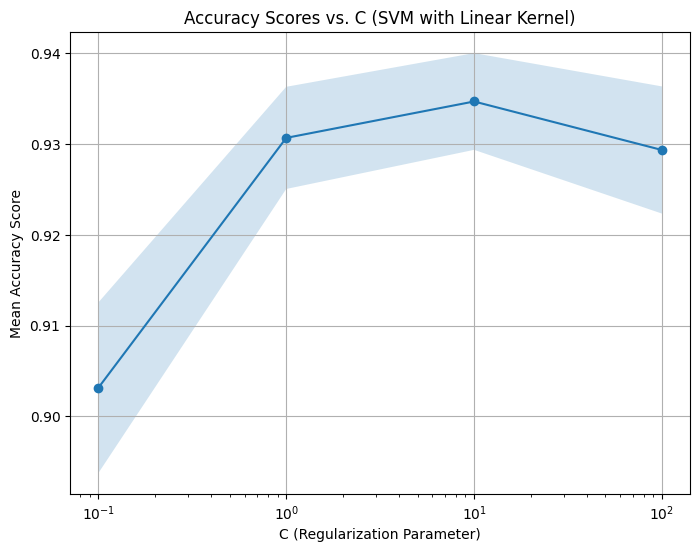

In [ ]:
# Plot Accuracy Scores vs. C
plt.figure(figsize=(8, 6))
plt.plot(results_linear['param_C'], results_linear['mean_test_score'], marker='o')
plt.fill_between(
    results_linear['param_C'],
    results_linear['mean_test_score'] - results_linear['std_test_score'],
    results_linear['mean_test_score'] + results_linear['std_test_score'],
    alpha=0.2
)
plt.xscale('log')
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('Mean Accuracy Score')
plt.title('Accuracy Scores vs. C (SVM with Linear Kernel)')
plt.grid()
plt.show()

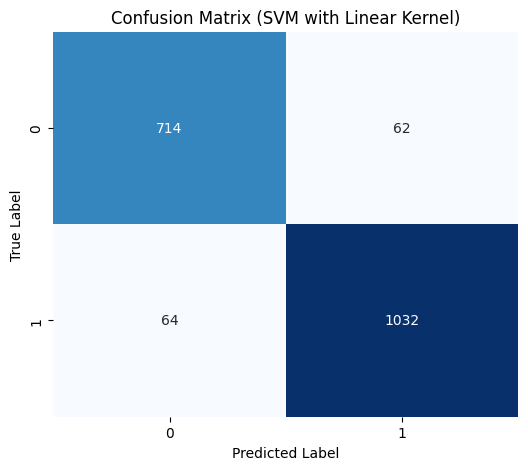

In [ ]:
# Confusion Matrix Heatmap
conf_matrix = confusion_matrix(y_test, y_pred_best_linear)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (SVM with Linear Kernel)')
plt.show()

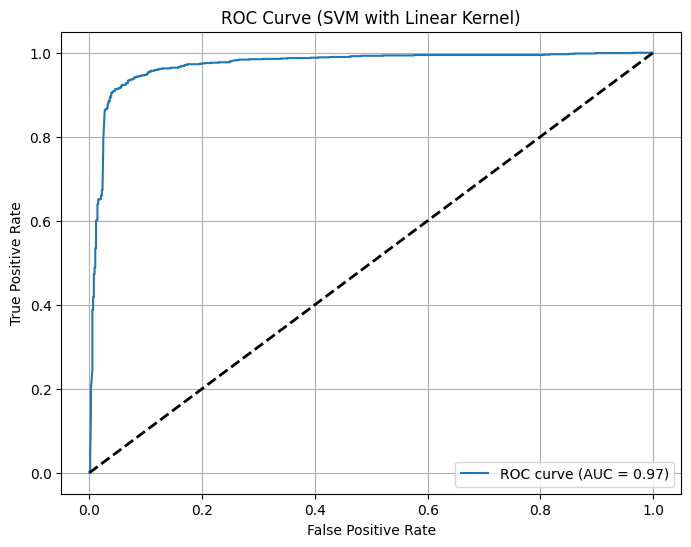

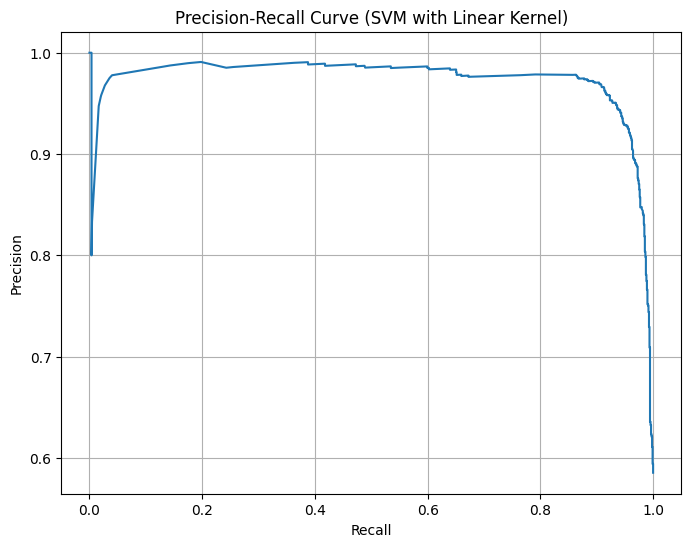

In [ ]:
# ROC Curve (for binary classification)
if len(set(y_test)) == 2:
    from sklearn.metrics import roc_curve, auc

    y_proba = best_svm_linear.decision_function(X_test_embedding)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (SVM with Linear Kernel)')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

# Precision-Recall Curve (for binary classification)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (SVM with Linear Kernel)')
    plt.grid()
    plt.show()

## Kernel RBF

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Parameter grid untuk kernel RBF
param_grid_rbf = {
    'C': [0.1, 1, 10, 100, 200],  # Nilai regularisasi C yang diperluas
    'gamma': [0.1, 1, 10]   # Nilai gamma untuk kernel RBF
}

# Inisialisasi model SVM dengan kernel RBF
svm_rbf = SVC(kernel='rbf')

# Inisialisasi GridSearchCV dengan 5-fold cross-validation
grid_search_rbf = GridSearchCV(
    estimator=svm_rbf,
    param_grid=param_grid_rbf,
    scoring='accuracy',
    cv=5,
    return_train_score=True  # Tambahkan untuk melihat skor pada data training
)

# Latih model menggunakan GridSearchCV dengan input embedding
print("Optimasi model SVM kernel RBF menggunakan GridSearchCV...")
grid_search_rbf.fit(X_train_embedding, y_train)

# Tampilkan parameter terbaik dan skor terbaik saat pelatihan
print("Best Parameters (RBF Kernel):", grid_search_rbf.best_params_)
print("Best Mean Test Score (RBF Kernel):", grid_search_rbf.best_score_)

# Tampilkan akurasi untuk setiap kombinasi parameter yang dicoba, dan simpan hasilnya dalam results_rbf
results_rbf = pd.DataFrame(grid_search_rbf.cv_results_)
results_rbf = results_rbf[['param_C', 'param_gamma', 'mean_test_score', 'std_test_score']]

# Lakukan prediksi pada data uji untuk setiap model hasil GridSearchCV dan hitung akurasi uji
test_accuracies = []
for params in grid_search_rbf.cv_results_['params']:
    svm_model = SVC(kernel='rbf', C=params['C'], gamma=params['gamma'])
    svm_model.fit(X_train_embedding, y_train)
    y_pred = svm_model.predict(X_test_embedding)
    test_accuracy = accuracy_score(y_test, y_pred)
    test_accuracies.append(test_accuracy)

# Tambahkan akurasi uji ke DataFrame hasil
results_rbf['test_accuracy'] = test_accuracies

print("\nPerbandingan akurasi untuk setiap kombinasi parameter C dan gamma:")
print(results_rbf)

# Ambil model terbaik dan lakukan prediksi pada data uji
best_svm_rbf = grid_search_rbf.best_estimator_
y_pred_best_rbf = best_svm_rbf.predict(X_test_embedding)

# Evaluasi hasil prediksi pada dataset uji
print("\nEvaluasi Model SVM dengan Kernel RBF (Parameter Terbaik):")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred_best_rbf):.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_best_rbf)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_best_rbf)}")

Optimasi model SVM kernel RBF menggunakan GridSearchCV...
Best Parameters (RBF Kernel): {'C': 10, 'gamma': 1}
Best Mean Test Score (RBF Kernel): 0.9401561467394067

Perbandingan akurasi untuk setiap kombinasi parameter C dan gamma:
    param_C  param_gamma  mean_test_score  std_test_score  test_accuracy
0       0.1          0.1         0.875500        0.009324       0.885150
1       0.1          1.0         0.915174        0.004773       0.918269
2       0.1         10.0         0.879775        0.011163       0.884081
3       1.0          0.1         0.919315        0.006476       0.923611
4       1.0          1.0         0.936549        0.003972       0.937500
5       1.0         10.0         0.915175        0.008377       0.920406
6      10.0          0.1         0.935747        0.004516       0.938568
7      10.0          1.0         0.940156        0.006015       0.936432
8      10.0         10.0         0.915575        0.007664       0.916132
9     100.0          0.1         0.936

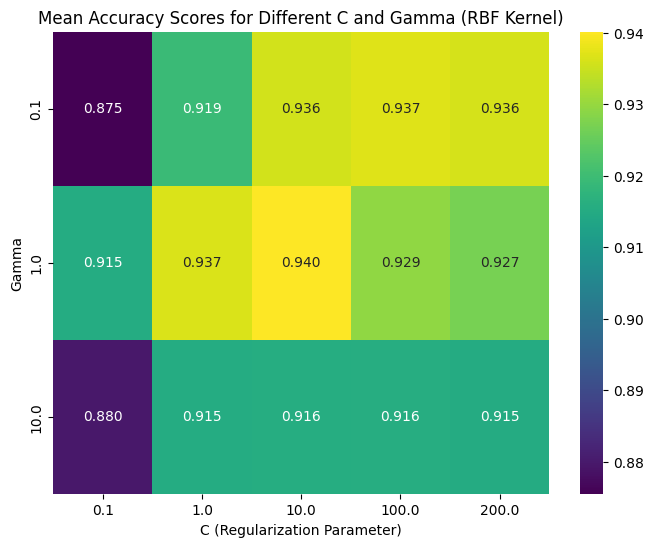

In [ ]:
# Membuat pivot table yang benar untuk menampilkan skor akurasi menggunakan results_rbf
pivot_table_rbf = results_rbf.pivot_table(
    index='param_gamma',
    columns='param_C',
    values='mean_test_score'
)

# Membuat heatmap dari pivot table
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table_rbf, annot=True, fmt='.3f', cmap='viridis')
plt.title('Mean Accuracy Scores for Different C and Gamma (RBF Kernel)')
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('Gamma')
plt.show()

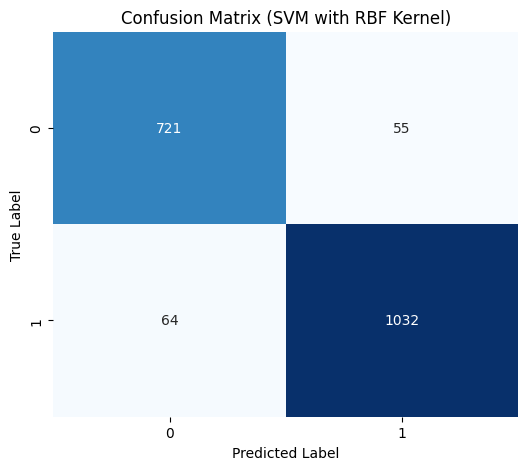

In [ ]:
# Confusion Matrix Heatmap
conf_matrix = confusion_matrix(y_test, y_pred_best_rbf)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (SVM with RBF Kernel)')
plt.show()

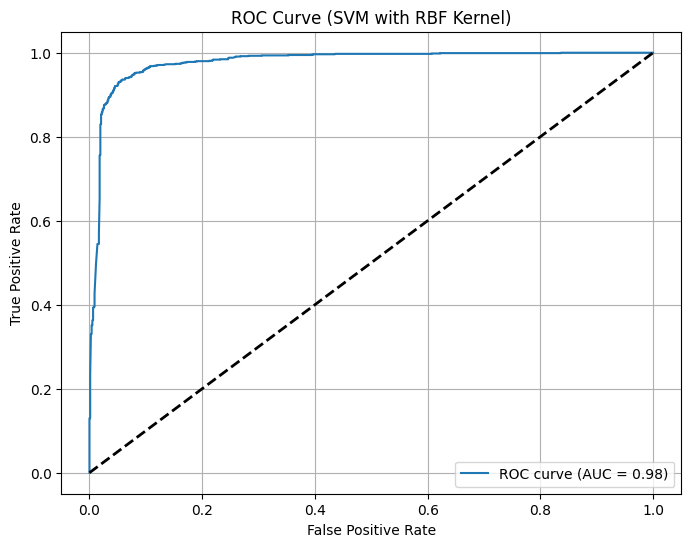

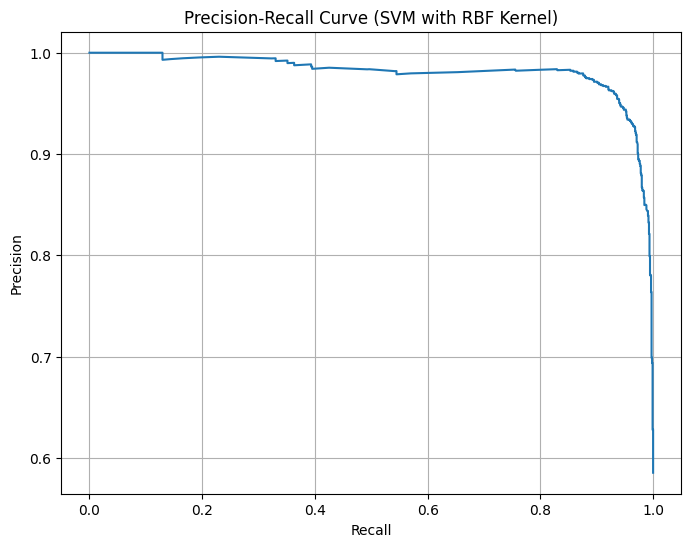

In [ ]:
# ROC Curve (for binary classification)
if len(set(y_test)) == 2:
    y_proba = best_svm_rbf.decision_function(X_test_embedding)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (SVM with RBF Kernel)')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

# Precision-Recall Curve (for binary classification)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (SVM with RBF Kernel)')
    plt.grid()
    plt.show()

## Kernel Polynomial

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Definisikan parameter grid untuk kernel Polynomial (Poly)
param_grid_poly = {
    'C': [0.1, 1, 10, 100],      # Nilai regularisasi C
    'gamma': [0.1, 1, 10],  # Nilai gamma yang diperluas untuk kernel Poly
    'degree': [2, 3, 4]          # Derajat polinomial (degree)
}

# Inisialisasi model SVM dengan kernel Polynomial (Poly)
svm_poly = SVC(kernel='poly')

# Inisialisasi GridSearchCV dengan 5-fold cross-validation
grid_search_poly = GridSearchCV(
    estimator=svm_poly,
    param_grid=param_grid_poly,
    scoring='accuracy',
    cv=5,
    return_train_score=True  # Tambahkan ini agar kita bisa melihat akurasi dari setiap kombinasi parameter
)

# Latih model menggunakan GridSearchCV dengan input TF-IDF atau embedding
print("Optimasi model SVM kernel Polynomial menggunakan GridSearchCV...")
grid_search_poly.fit(X_train_embedding, y_train)

# Tampilkan parameter terbaik dan skor terbaik saat pelatihan
print("Best Parameters (Poly Kernel):", grid_search_poly.best_params_)
print("Best Accuracy Score (Poly Kernel):", grid_search_poly.best_score_)

# Tampilkan akurasi untuk setiap kombinasi parameter yang dicoba, dan simpan hasilnya dalam results_poly
results_poly = pd.DataFrame(grid_search_poly.cv_results_)
results_poly = results_poly[['param_C', 'param_gamma', 'param_degree', 'mean_test_score', 'std_test_score']]
print("\nPerbandingan akurasi untuk setiap kombinasi parameter C, gamma, dan degree:")
print(results_poly)

# Ambil model terbaik dan lakukan prediksi pada data uji
best_svm_poly = grid_search_poly.best_estimator_
y_pred_best_poly = best_svm_poly.predict(X_test_embedding)

# Evaluasi hasil prediksi pada dataset uji
print("\nEvaluasi Model SVM dengan Kernel Polynomial (Parameter Terbaik):")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred_best_poly):.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_best_poly)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_best_poly)}")

Optimasi model SVM kernel Polynomial menggunakan GridSearchCV...
Best Parameters (Poly Kernel): {'C': 0.1, 'degree': 2, 'gamma': 10}
Best Accuracy Score (Poly Kernel): 0.9338767432506312

Perbandingan akurasi untuk setiap kombinasi parameter C, gamma, dan degree:
    param_C  param_gamma  param_degree  mean_test_score  std_test_score
0       0.1          0.1             2         0.586161        0.001232
1       0.1          1.0             2         0.884716        0.010024
2       0.1         10.0             2         0.933877        0.005358
3       0.1          0.1             3         0.585226        0.000437
4       0.1          1.0             3         0.860403        0.011636
5       0.1         10.0             3         0.926129        0.004320
6       0.1          0.1             4         0.585226        0.000437
7       0.1          1.0             4         0.859602        0.013380
8       0.1         10.0             4         0.918114        0.005602
9       1.0     

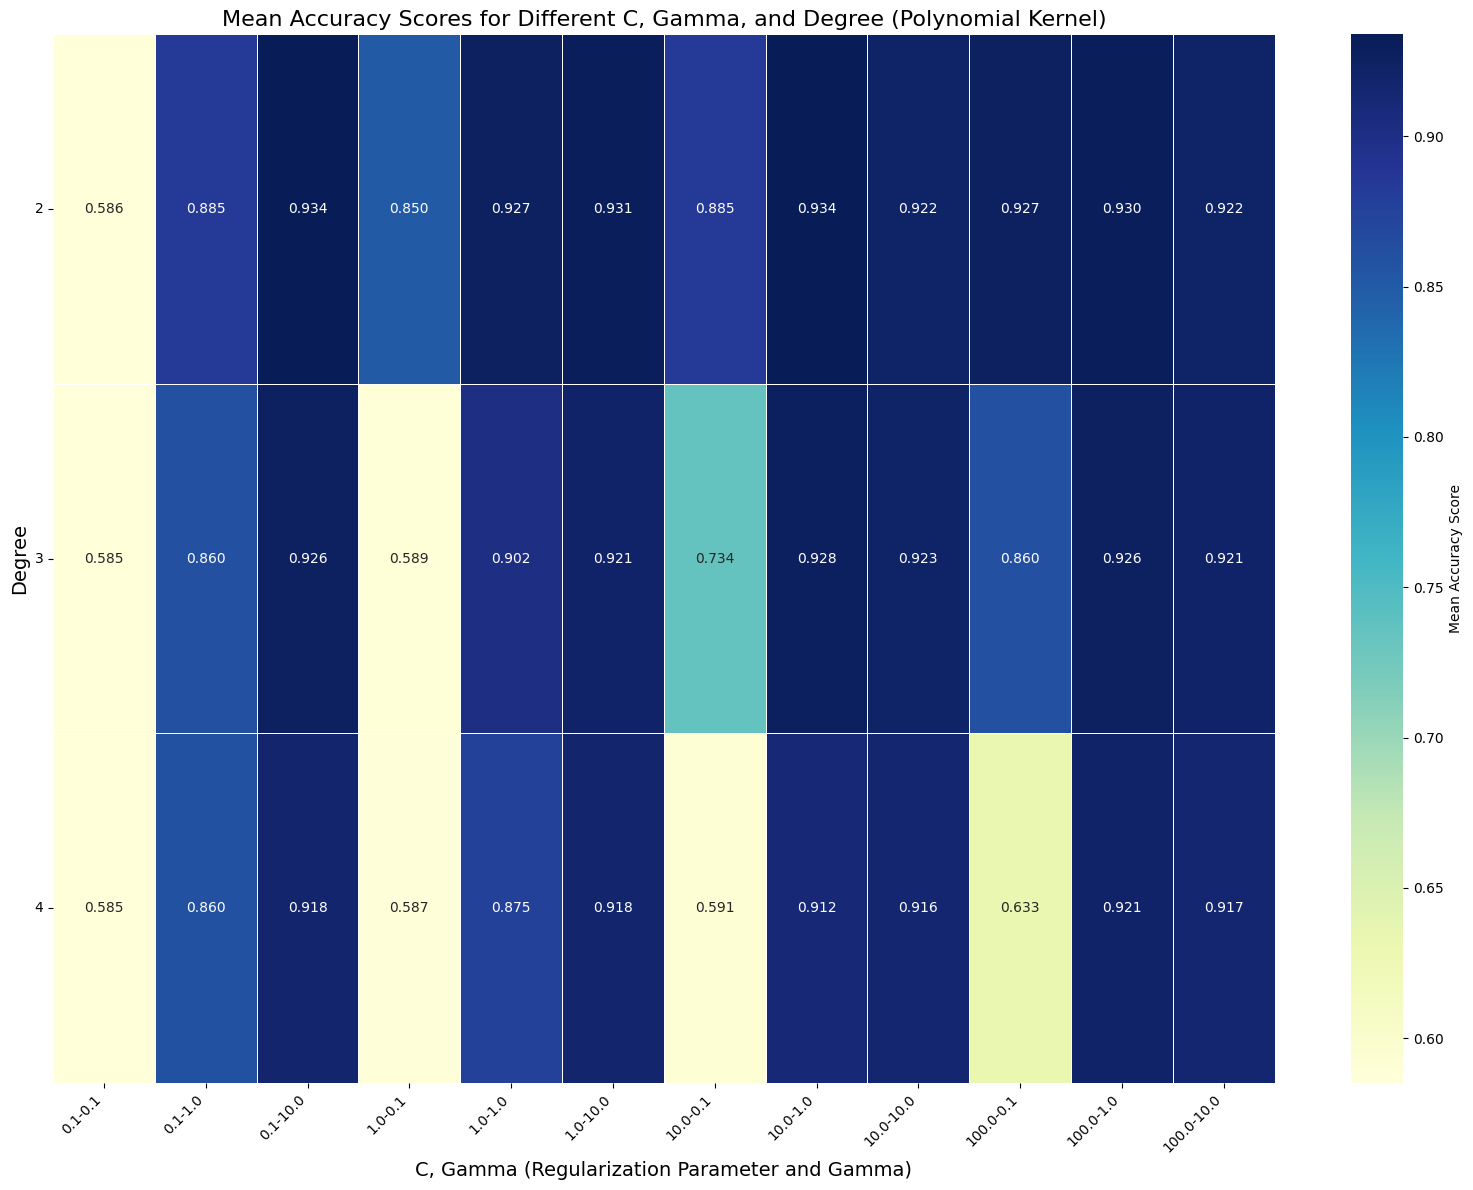

In [ ]:
# Membuat pivot table untuk berbagai kombinasi parameter menggunakan results_poly
pivot_table_poly = results_poly.pivot_table(
    index='param_degree',
    columns=['param_C', 'param_gamma'],
    values='mean_test_score'
)

# Atur ukuran heatmap agar lebih besar
plt.figure(figsize=(16, 12))

# Membuat heatmap untuk akurasi rata-rata
sns.heatmap(
    pivot_table_poly,
    annot=True,
    fmt='.3f',
    cmap='YlGnBu',
    linewidths=0.5,
    cbar_kws={'label': 'Mean Accuracy Score'}
)

# Pengaturan judul dan label sumbu
plt.title('Mean Accuracy Scores for Different C, Gamma, and Degree (Polynomial Kernel)', fontsize=16)
plt.xlabel('C, Gamma (Regularization Parameter and Gamma)', fontsize=14)
plt.ylabel('Degree', fontsize=14)

# Rotasi label sumbu x agar lebih rapi dan mudah dibaca
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Tampilkan heatmap
plt.tight_layout()  # Mengatur layout agar semua elemen grafik terlihat jelas
plt.show()

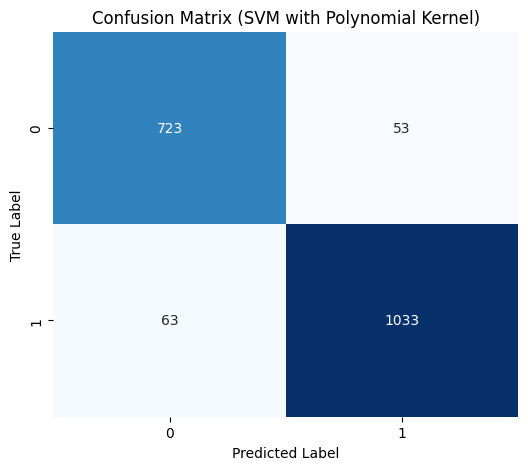

In [ ]:
# Confusion Matrix Heatmap
conf_matrix_poly = confusion_matrix(y_test, y_pred_best_poly)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_poly, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (SVM with Polynomial Kernel)')
plt.show()

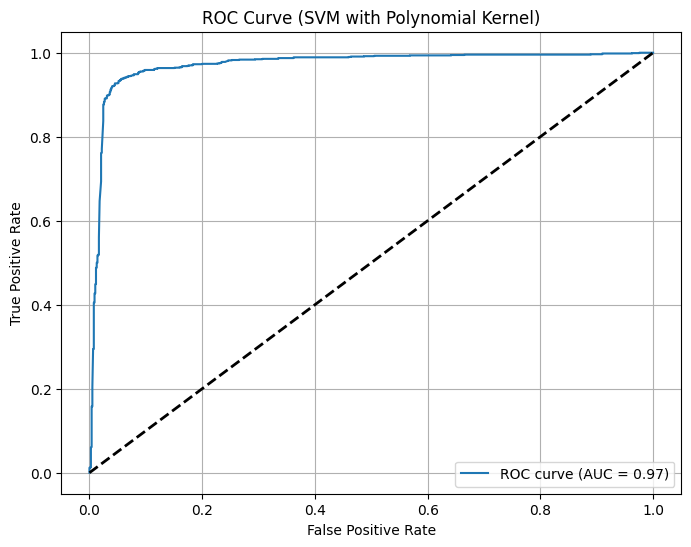

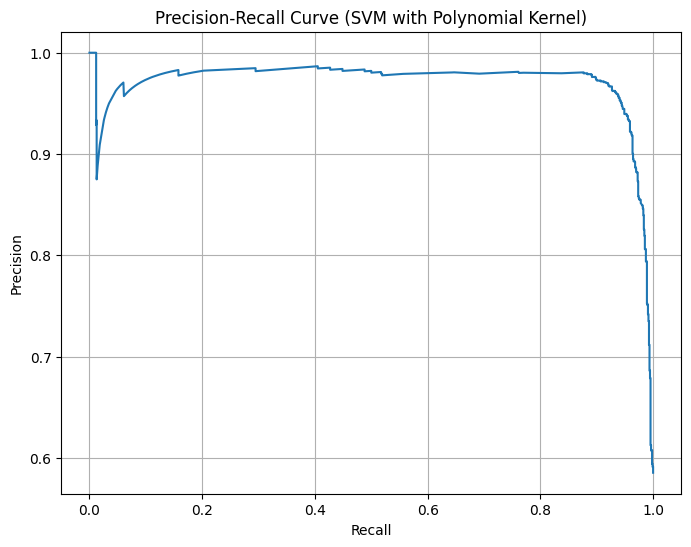

In [ ]:
# ROC Curve (for binary classification)
if len(set(y_test)) == 2:
    y_proba_poly = best_svm_poly.decision_function(X_test_embedding)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba_poly)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (SVM with Polynomial Kernel)')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

# Precision-Recall Curve (for binary classification)
    precision, recall, _ = precision_recall_curve(y_test, y_proba_poly)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (SVM with Polynomial Kernel)')
    plt.grid()
    plt.show()